In [52]:
import torch
import matplotlib.pyplot as plt

import data
import models
import copy

In [53]:
MAX_ITER = 500000
LR = 0.0001
BATCH_SIZE = 1
MAX_CONTEXT = 5
MAX_TARGET = 5
IN_SHAPE = (1, 5)
HIDDEN_SIZE = 128
NUM_HIDDEN_LAYERS = 2
MIN_STD = 0.01
LATENT_DIM = 16

In [54]:
from environment import Environment
env = Environment(gui = 0)
def get_angle(traj):
    env.reset()
    pos_pred = env.use_joint_series(traj)
    ds = pos_pred[-1] - pos_pred[0]
    k = torch.arctan(torch.tensor(ds[2] / ds[1]))/torch.pi * 180 
    return k.item() , pos_pred 

argv[0]=
Loaded EGL 1.5 after reload.


EGL device choice: -1 of 3.


GL_VENDOR=NVIDIA Corporation
GL_RENDERER=NVIDIA GeForce RTX 4090/PCIe/SSE2
GL_VERSION=4.6.0 NVIDIA 535.86.05
GL_SHADING_LANGUAGE_VERSION=4.60 NVIDIA
Version = 4.6.0 NVIDIA 535.86.05
Vendor = NVIDIA Corporation
Renderer = NVIDIA GeForce RTX 4090/PCIe/SSE2
b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base_footprintb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base/link_tipb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrd

In [55]:
trainset = data.JointLandmarkDataset("data/ver4_1/joints.pt", "data/ver4_1/landmarks.pt")
valset = data.JointLandmarkDataset("data/ver4_val/joints.pt", "data/ver4_val/landmarks.pt", phase=3.14/12)

In [56]:
model = models.MMCNP(in_shape=IN_SHAPE, hidden_size=HIDDEN_SIZE,
                   num_hidden_layers=NUM_HIDDEN_LAYERS, min_std=MIN_STD, latent_dim=LATENT_DIM)
model_cp = None
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

In [57]:
sum(p.numel() for p in model.parameters())

22638

In [58]:
avg_loss = 0.0
avg_val_loss = 0.0
best_val_loss = 0.0

for it in range(MAX_ITER):
    # sample data
    context, target, context_mask, target_mask = trainset.get_sample(batch_size=BATCH_SIZE,
                                                                     max_context=MAX_CONTEXT,
                                                                     max_target=MAX_TARGET)
    # compute loss
    loss = model.nll_loss(observation=context,
                          target=(target[0][..., [0]],target[1][..., [0]]),  # 0 contains timestep which is our query dimension
                          target_truth=(target[0][..., 1:],target[1][..., 1:]),
                          observation_mask=context_mask,
                          target_mask=target_mask)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    avg_loss += loss.item()
    if (it+1) % 1000 == 0:
        for i in range(200):
            with torch.no_grad():
                context, target, context_mask, target_mask = valset.get_sample(batch_size=BATCH_SIZE,
                                                                        max_context=MAX_CONTEXT,
                                                                        max_target=MAX_TARGET)
        # compute loss
                val_loss = model.nll_loss(observation=context,
                                    target=(target[0][..., [0]],target[1][..., [0]]),  # 0 contains timestep which is our query dimension
                                    target_truth=(target[0][..., 1:],target[1][..., 1:]),
                                    observation_mask=context_mask,
                                    target_mask=target_mask)
                avg_val_loss += val_loss.item()
        print(f"iter={it}, loss={avg_loss / 1000}, val_loss= {avg_val_loss/200}")
        for act in range(valset.joint.shape[0]):
            obs_joints = valset.joint[act:act+1 , [5,10,15,20,25], :]  # only the first timestep is observed
            obs_landmarks = valset.landmark[act:act+1 , [5,10,15,20,25], :] 
            target_joints = valset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
            target_landmarks = valset.landmark[[act], :, :1]
            obs = (None, obs_landmarks)
            target = (target_joints, target_landmarks)
            with torch.no_grad():
                mean, std, land_1 , land_std = model(obs, target,observation_mask=(None, None) )
            pred , pred_pos= get_angle(mean[0])
            org, org_pos = get_angle(valset.joint[act, :, 1:])
            print(f"action{act}: actual angle = {org}, pred_angle = {pred}")
        if avg_val_loss < best_val_loss:
            model_cp = copy.deepcopy(model)
            best_val_loss = avg_val_loss
        avg_loss = 0
        avg_val_loss = 0
        avg_loss = 0 

iter=999, loss=0.41164131751284005, val_loss= -0.3991334322094917
action0: actual angle = 8.786212355316799, pred_angle = 59.71537920298543
action1: actual angle = 44.23219888479632, pred_angle = 59.71305872013855
action2: actual angle = 75.90765204605606, pred_angle = 62.72174296805081
action3: actual angle = -72.34725885389813, pred_angle = 51.484054334619834
action4: actual angle = -37.68819761847156, pred_angle = 51.753783740240664
action5: actual angle = -1.47054509948909, pred_angle = 51.08817439505233
action6: actual angle = 31.21351656861004, pred_angle = 50.58795277175735
iter=1999, loss=-0.5285981306135654, val_loss= -0.5866399835422635
action0: actual angle = 8.801832503925079, pred_angle = 39.34351490523204
action1: actual angle = 44.23492432558405, pred_angle = 42.265473490935456
action2: actual angle = 75.85026649215791, pred_angle = 36.140743094281895
action3: actual angle = -72.41823639663059, pred_angle = 86.16372680419154
action4: actual angle = -37.69580597528428, pr

KeyboardInterrupt: 

In [70]:
model = model_cp

In [71]:
avg_val_loss = 0
for i in range(200):
            with torch.no_grad():
                context, target, context_mask, target_mask = valset.get_sample(batch_size=BATCH_SIZE,
                                                                        max_context=MAX_CONTEXT,
                                                                        max_target=MAX_TARGET)
        # compute loss
                val_loss = model.nll_loss(observation=context,
                                    target=(target[0][..., [0]],target[1][..., [0]]),  # 0 contains timestep which is our query dimension
                                    target_truth=(target[0][..., 1:],target[1][..., 1:]),
                                    observation_mask=context_mask,
                                    target_mask=target_mask)
                avg_val_loss += val_loss.item()

In [72]:
avg_val_loss / 200

-4.352605548202991

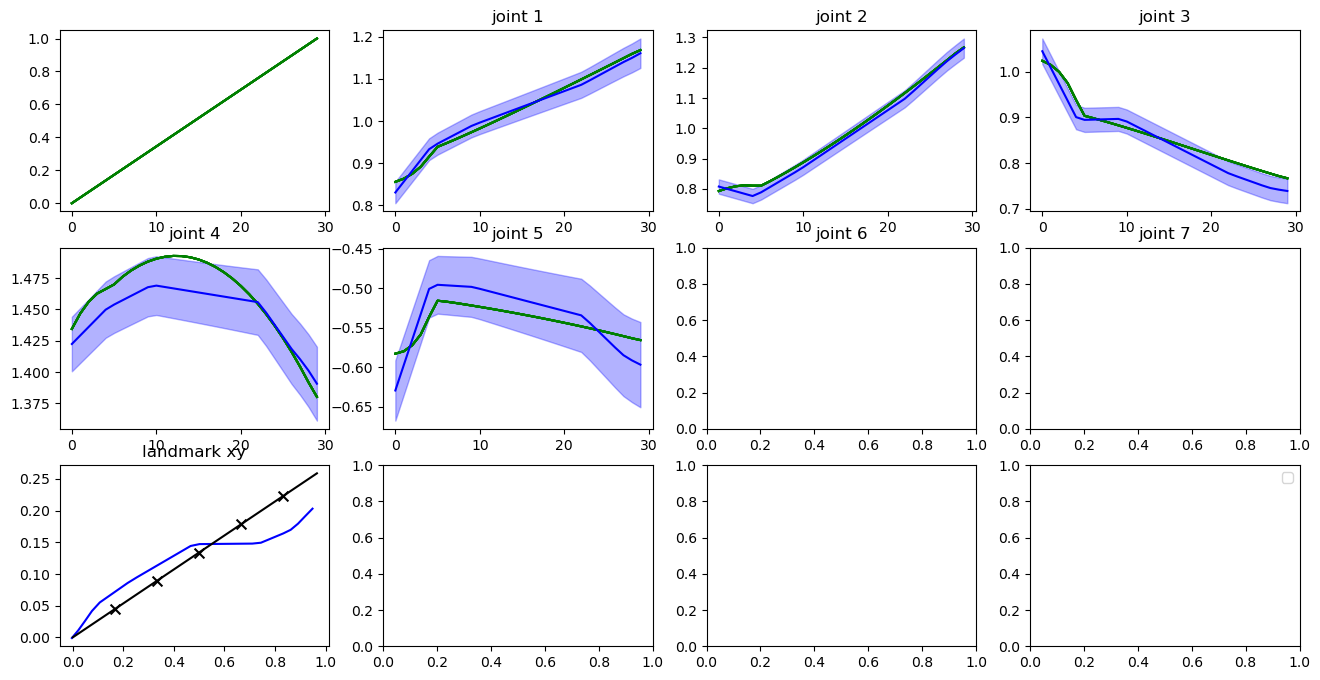

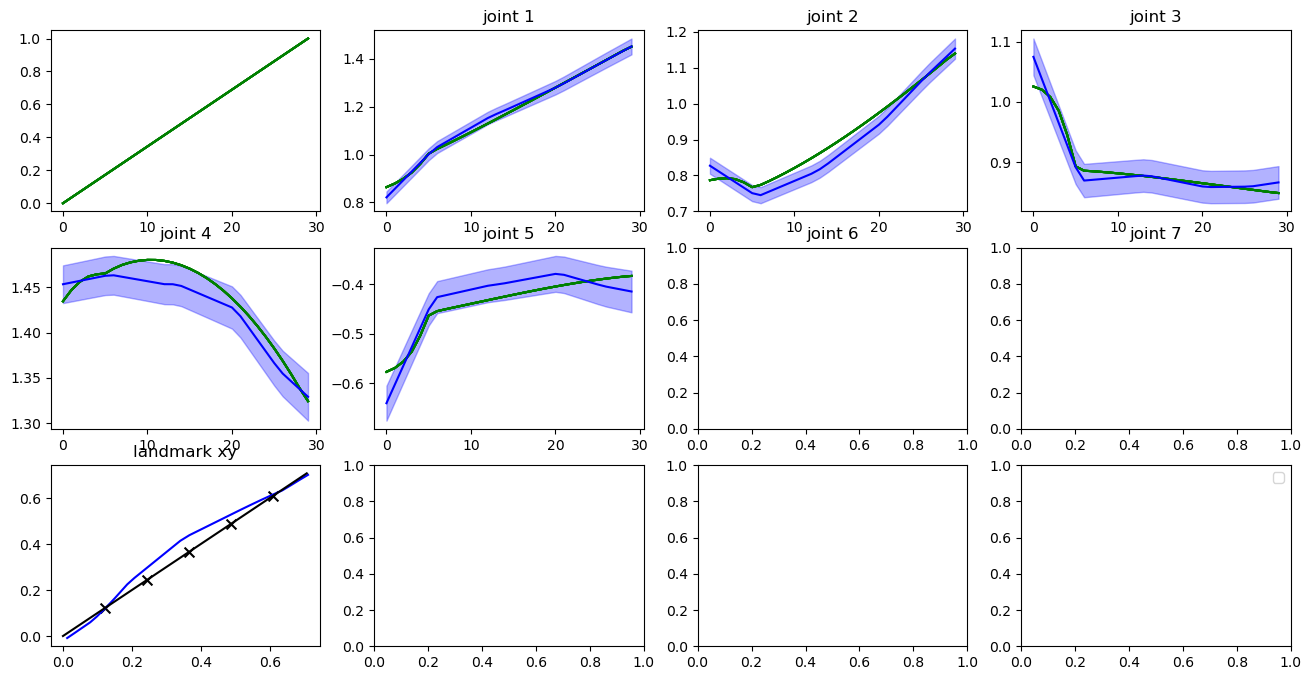

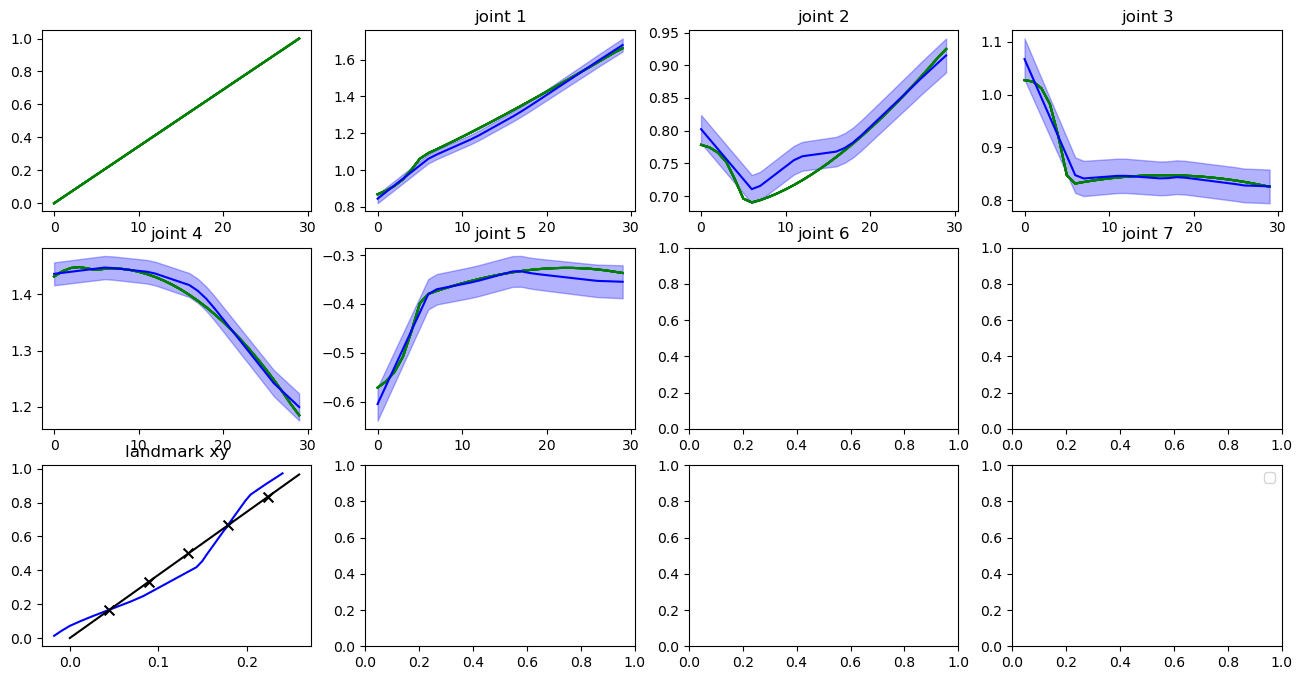

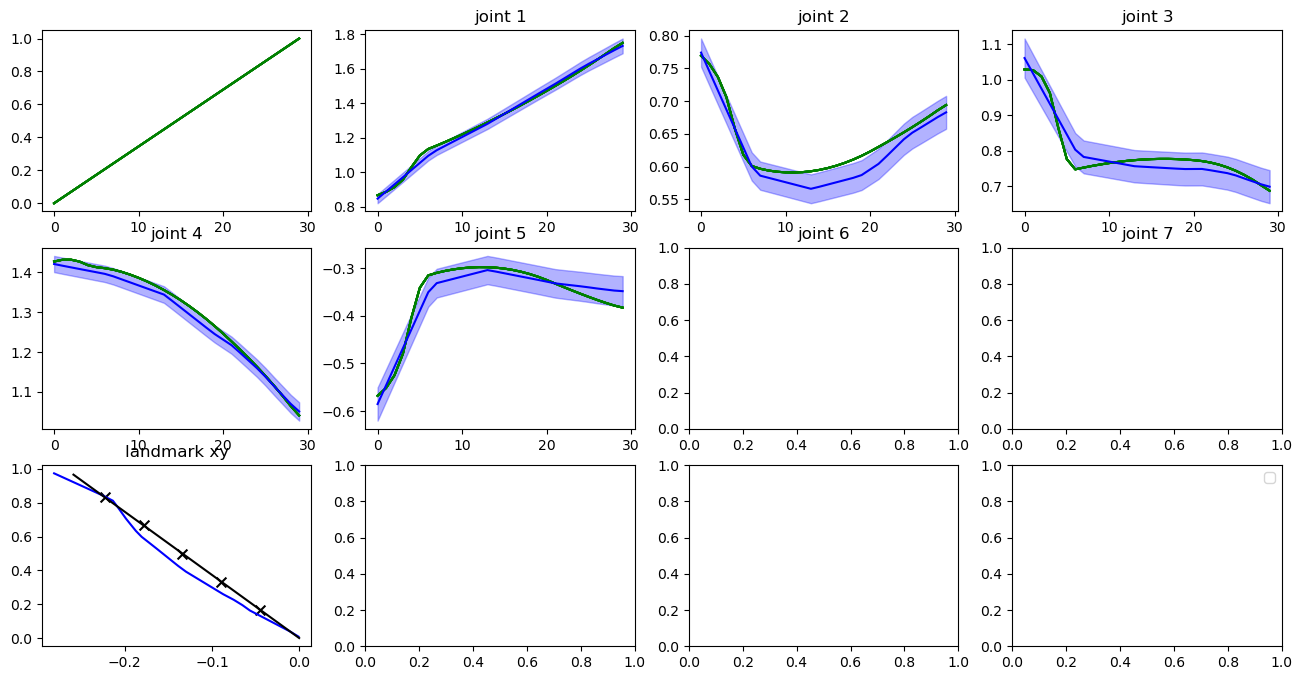

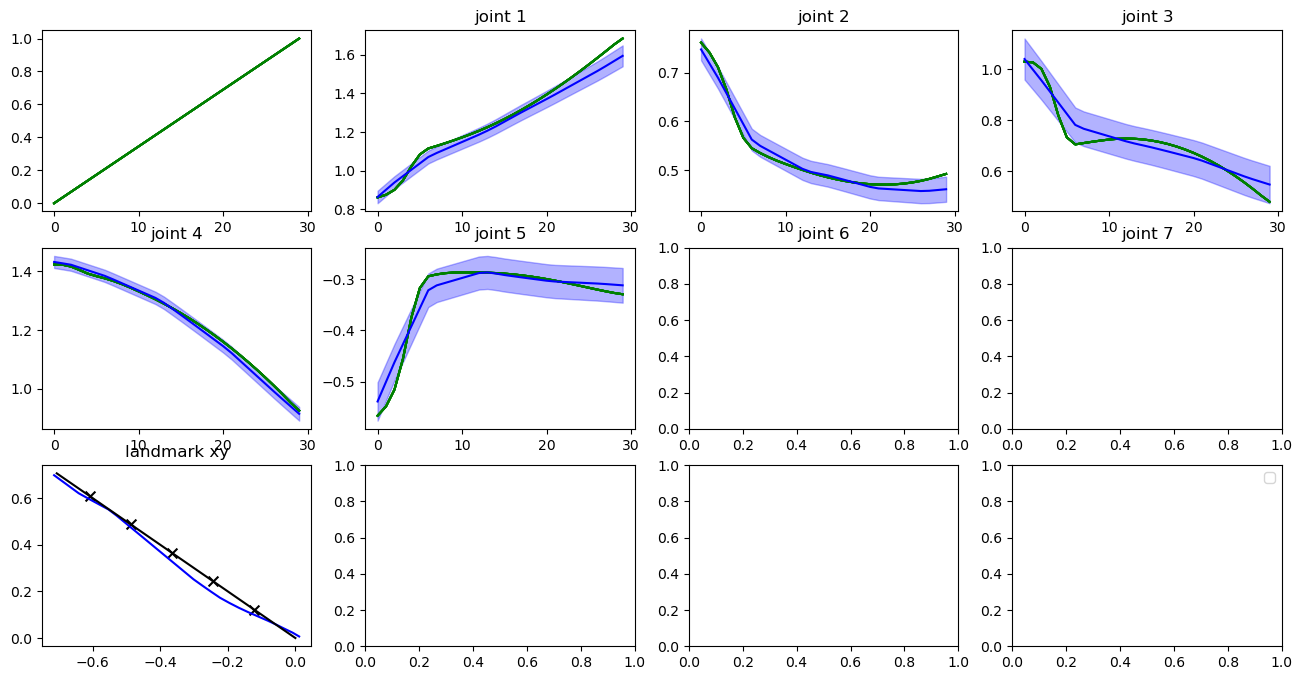

In [73]:
valset.data = valset.joint
for act in range(5):
    obs_joints = valset.joint[act:act+1 , [5,10,15,20,25], :]  # only the first timestep is observed
    obs_landmarks = valset.landmark[act:act+1 , [5,10,15,20,25], :] 
    target_joints = valset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
    target_landmarks = valset.landmark[[act], :, :1]
    obs = (None, obs_landmarks)
    target = (target_joints, target_landmarks)
    with torch.no_grad():
        mean, std, land_1 , land_std = model(obs, target,observation_mask=(None, None) )

    fig, ax = plt.subplots(3, 4, figsize=(16, 8))
    for i in range(2):
        for j in range(4):
            idx = i * 4 + j
            
            for k in range(1,valset.data.shape[0]):
                if idx >= valset.data.shape[2]:
                    continue
                ax[i, j].plot(valset.data[act, :, idx], c="g", label = "data")
            
            if idx == 0:
                continue
            if obs[0] != None:
                ax[i, j].scatter(obs_joints[0, :, 0] * 30, obs_joints[0, :, idx], c="k", marker="x", s=50)  # what the model observed
            ax[i, j].set_title(f"joint {idx}")
            if idx - 1 >= mean.shape[-1]:
                continue  
            ax[i, j].plot(mean[0, :, idx-1], c="b",label = "pred")
            ax[i, j].fill_between(range(mean.shape[1]),
                                mean[0, :, idx-1] - 2*std[0, :, idx-1],
                                mean[0, :, idx-1] + 2*std[0, :, idx-1],
                                alpha=0.3, color="b")
            # ax[i, j].set_ylim(-2, 2)
    i = 2
    j = 0
    ax[i, j].scatter(obs_landmarks[0,:, 1], obs_landmarks[0 ,:, 2], c="k", marker="x", s=50)  # what the model observed
    mean = land_1
    std = land_std
    ax[i, j].plot(mean[0, :,0] ,mean[0, :,1], c="b",label = "pred")
    ax[i, j].plot(valset.landmark[act, :, 1],valset.landmark[act, :, 2], c="k",label = "pred")
    ax[i, j].set_title(f"landmark xy")
    # ax[i, j].fill_between(range(mean.shape[1]),
    #                     mean[:,0] - 2*std[0, 1],
    #                     mean[:,1] + 2*std[0, :, idx-1],
    #                     alpha=0.3, color="b")
    plt.legend()


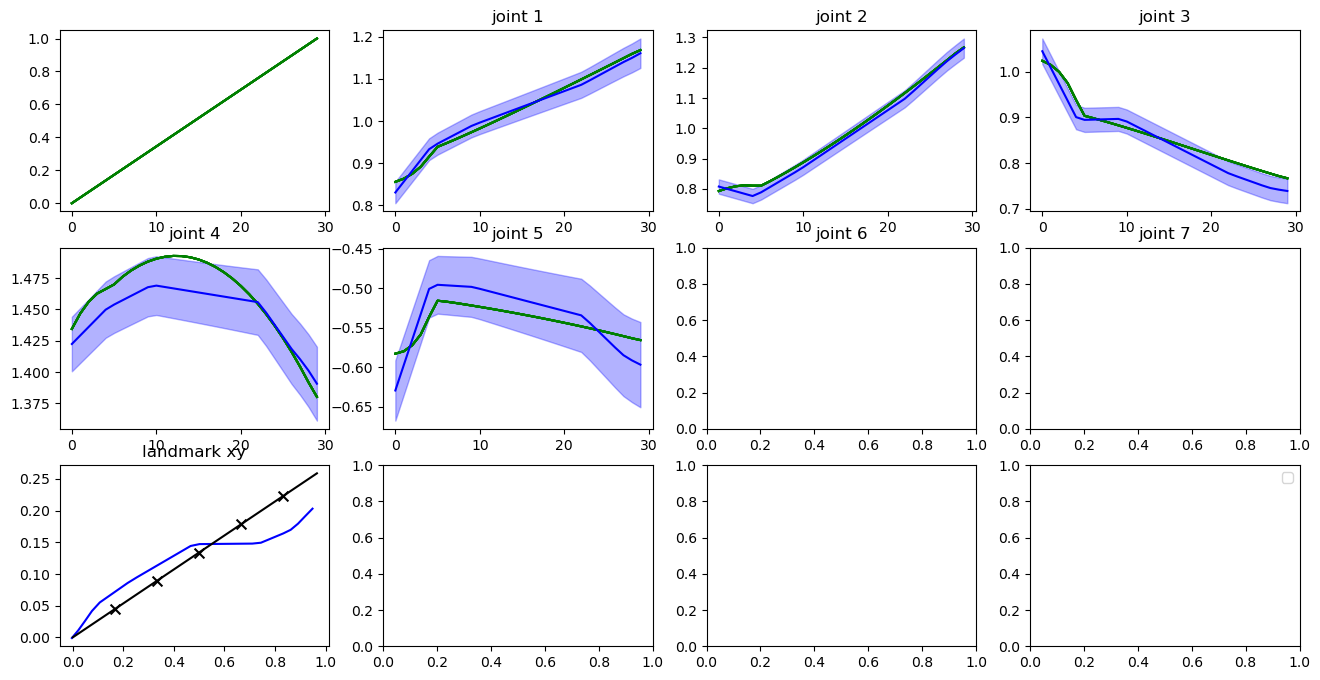

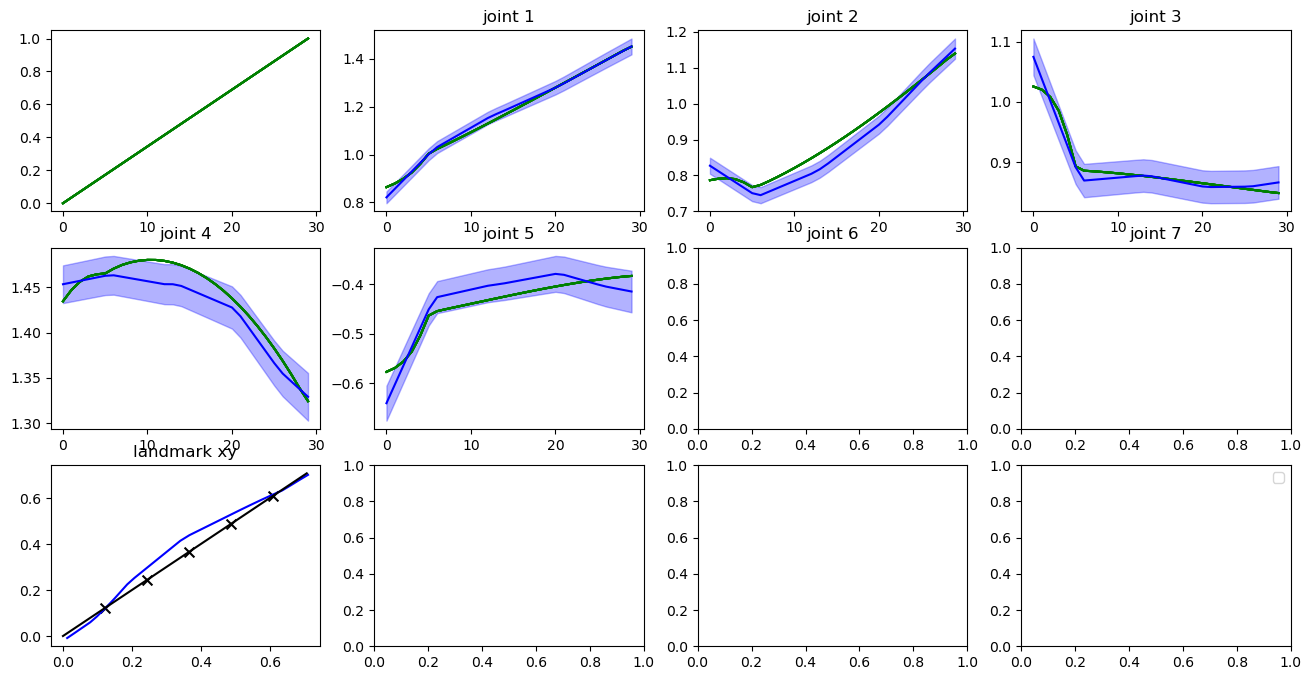

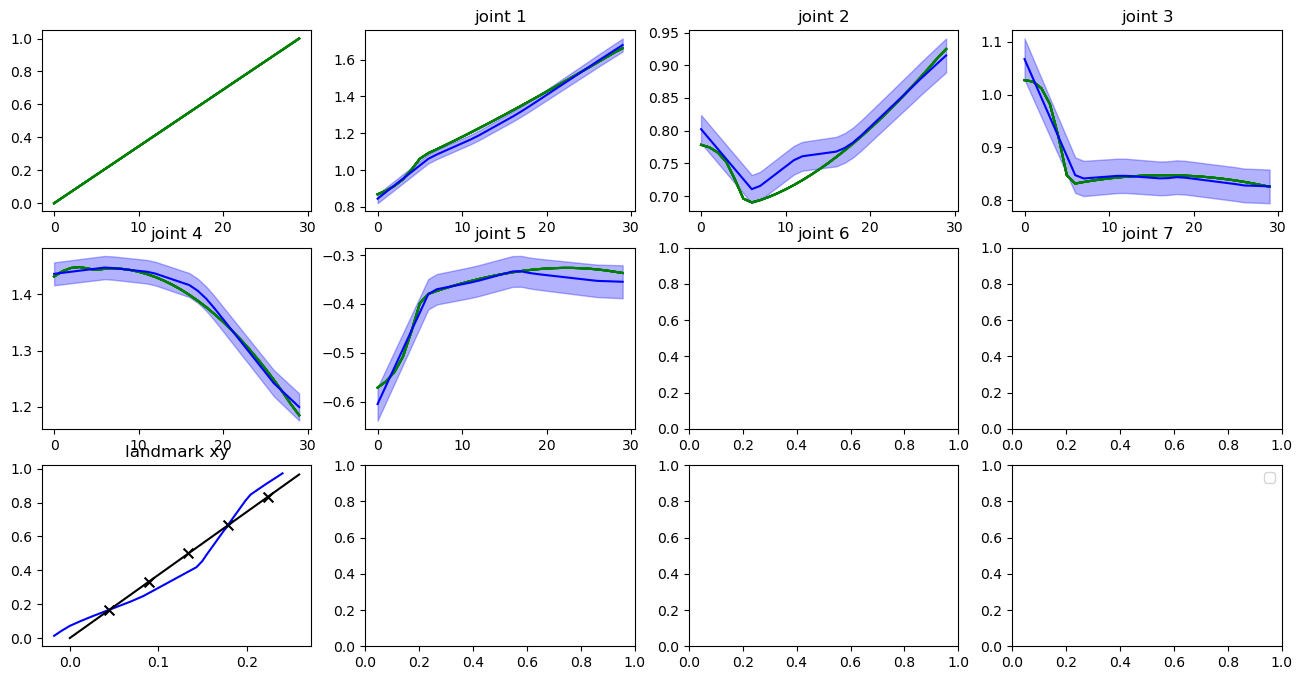

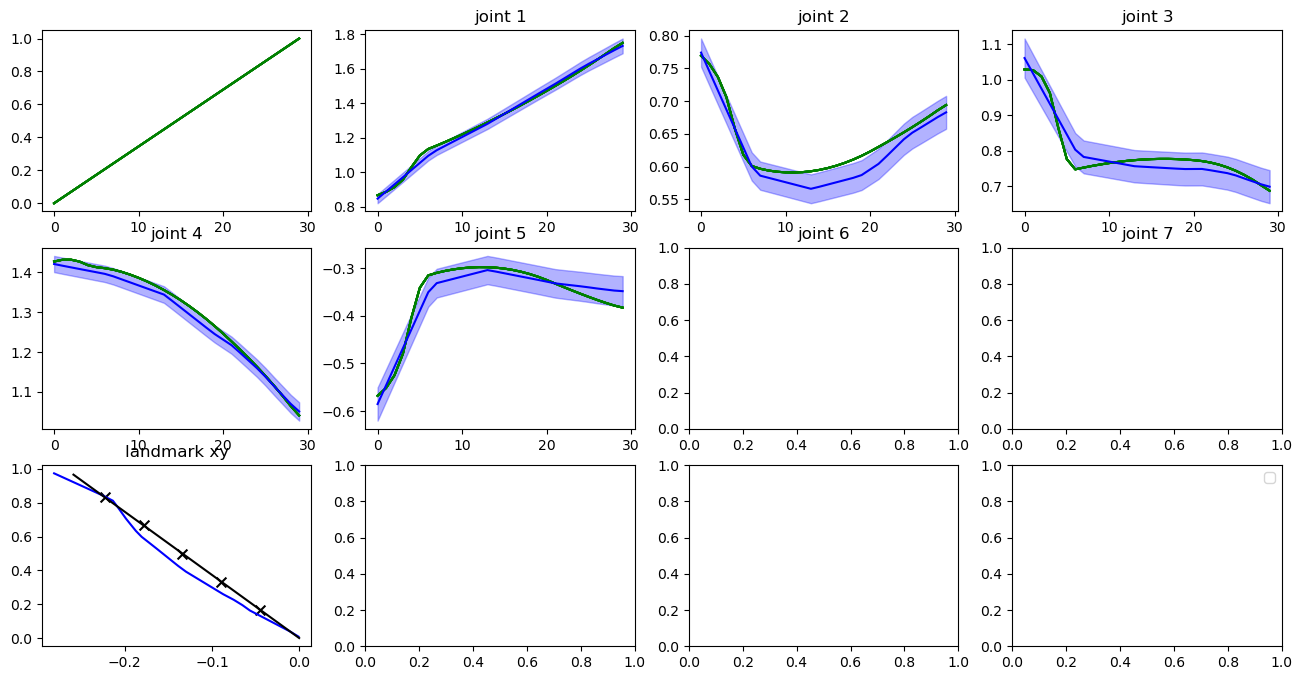

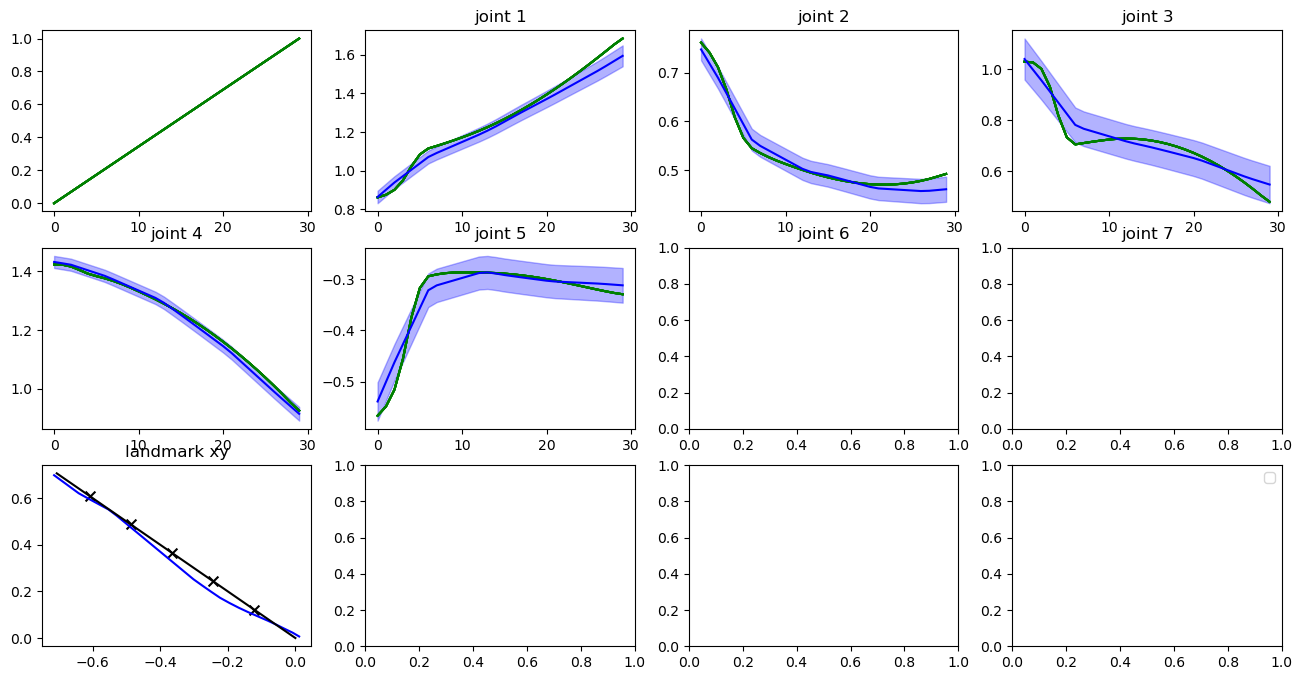

In [74]:
valset.data = valset.joint
for act in range(5):
    obs_joints = valset.joint[act:act+1 , [5,10,15,20,25], :]  # only the first timestep is observed
    obs_landmarks = valset.landmark[act:act+1 , [5,10,15,20,25], :] 
    target_joints = valset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
    target_landmarks = valset.landmark[[act], :, :1]
    obs = (None, obs_landmarks)
    target = (target_joints, target_landmarks)
    with torch.no_grad():
        mean, std, land_1 , land_std = model_cp(obs, target,observation_mask=(None, None) )

    fig, ax = plt.subplots(3, 4, figsize=(16, 8))
    for i in range(2):
        for j in range(4):
            idx = i * 4 + j
            
            for k in range(1,valset.data.shape[0]):
                if idx >= valset.data.shape[2]:
                    continue
                ax[i, j].plot(valset.data[act, :, idx], c="g", label = "data")
            
            if idx == 0:
                continue
            if obs[0] != None:
                ax[i, j].scatter(obs_joints[0, :, 0] * 30, obs_joints[0, :, idx], c="k", marker="x", s=50)  # what the model observed
            ax[i, j].set_title(f"joint {idx}")
            if idx - 1 >= mean.shape[-1]:
                continue  
            ax[i, j].plot(mean[0, :, idx-1], c="b",label = "pred")
            ax[i, j].fill_between(range(mean.shape[1]),
                                mean[0, :, idx-1] - 2*std[0, :, idx-1],
                                mean[0, :, idx-1] + 2*std[0, :, idx-1],
                                alpha=0.3, color="b")
            # ax[i, j].set_ylim(-2, 2)
    i = 2
    j = 0
    ax[i, j].scatter(obs_landmarks[0,:, 1], obs_landmarks[0 ,:, 2], c="k", marker="x", s=50)  # what the model observed
    mean = land_1
    std = land_std
    ax[i, j].plot(mean[0, :,0] ,mean[0, :,1], c="b",label = "pred")
    ax[i, j].plot(valset.landmark[act, :, 1],valset.landmark[act, :, 2], c="k",label = "pred")
    ax[i, j].set_title(f"landmark xy")
    # ax[i, j].fill_between(range(mean.shape[1]),
    #                     mean[:,0] - 2*std[0, 1],
    #                     mean[:,1] + 2*std[0, :, idx-1],
    #                     alpha=0.3, color="b")
    plt.legend()


In [75]:
act = 3
obs_joints = valset.joint[act:act+1 , [5,10,15,20,25], :]  # only the first timestep is observed
obs_landmarks = valset.landmark[act:act+1 , [5,10,15,20,25], :] 
target_joints = valset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
target_landmarks = valset.landmark[[act], :, :1]
obs = (None, obs_landmarks)
target = (target_joints, target_landmarks)
with torch.no_grad():
    mean, std, land_1 , land_std = model(obs, target,observation_mask=(None, None) )

In [76]:
mean[0].shape

torch.Size([30, 5])

In [77]:
env.reset()

In [78]:
valset.joint.shape

torch.Size([7, 30, 6])

action0: actual angle = 15.795719861943326, pred_angle = 11.72787932354971


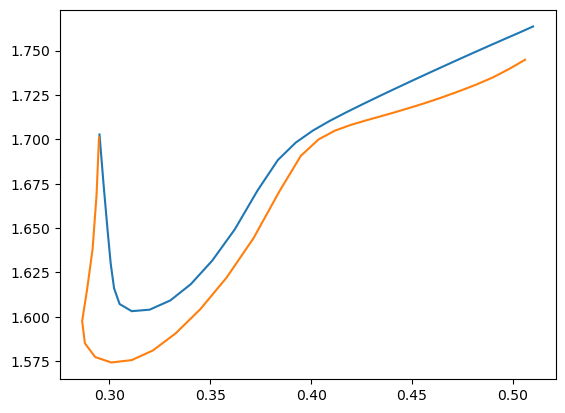

action1: actual angle = 53.44251952533035, pred_angle = 53.53166101122522


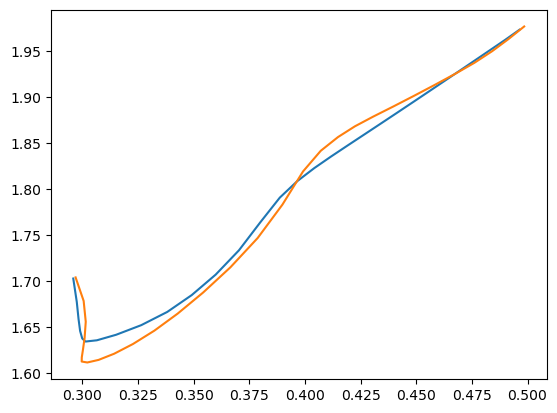

action2: actual angle = 72.60209598376943, pred_angle = 73.58310219981176


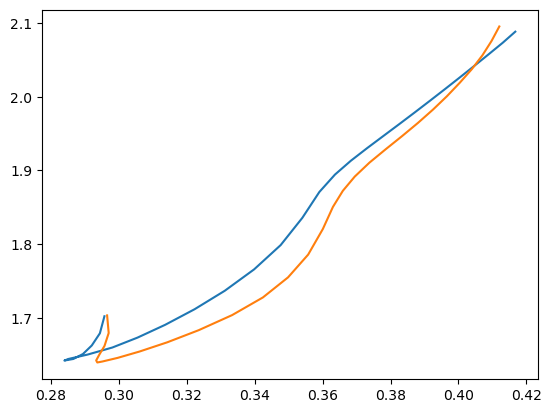

action3: actual angle = -88.70365683380183, pred_angle = -88.45103509645887


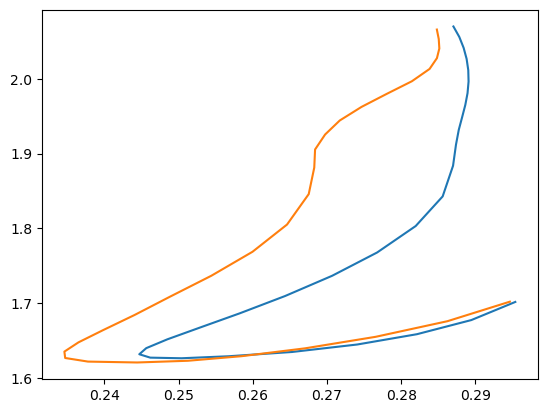

action4: actual angle = -54.99275173780316, pred_angle = -46.0983833775715


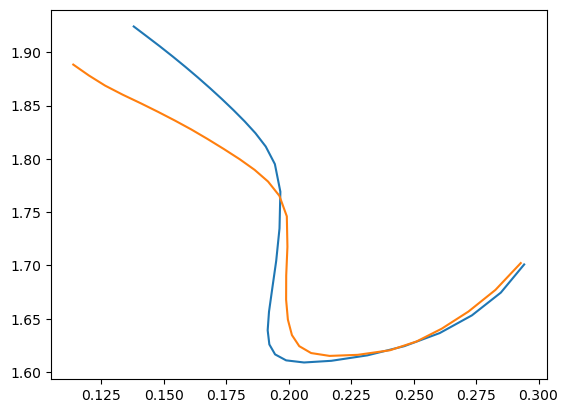

action5: actual angle = -3.2722975812431105, pred_angle = 0.9166166332268662


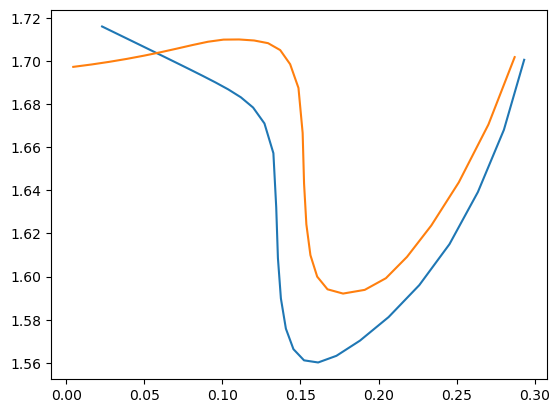

action6: actual angle = 30.757263682261982, pred_angle = 27.53896909801751


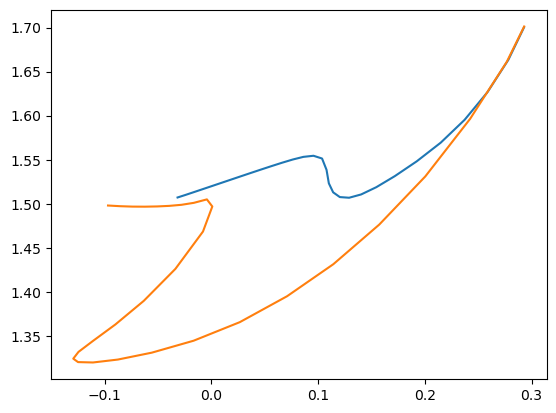

In [79]:
for act in range(valset.joint.shape[0]):
    obs_joints = valset.joint[act:act+1 , [5,10,15,20,25], :]  # only the first timestep is observed
    obs_landmarks = valset.landmark[act:act+1 , [5,10,15,20,25], :] 
    target_joints = valset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
    target_landmarks = valset.landmark[[act], :, :1]
    obs = (None, obs_landmarks)
    target = (target_joints, target_landmarks)
    with torch.no_grad():
        mean, std, land_1 , land_std = model(obs, target,observation_mask=(None, None) )
    pred , pred_pos= get_angle(mean[0])
    org, org_pos = get_angle(valset.joint[act, :, 1:])
    print(f"action{act}: actual angle = {org}, pred_angle = {pred}")
    plt.plot(org_pos[:,1], org_pos[:,2], label = "robot")
    plt.plot(pred_pos[:,1], pred_pos[:,2], label = "pred")
    plt.show()

action0: actual angle = 16.294385161265843, pred_angle = 19.088507923980703


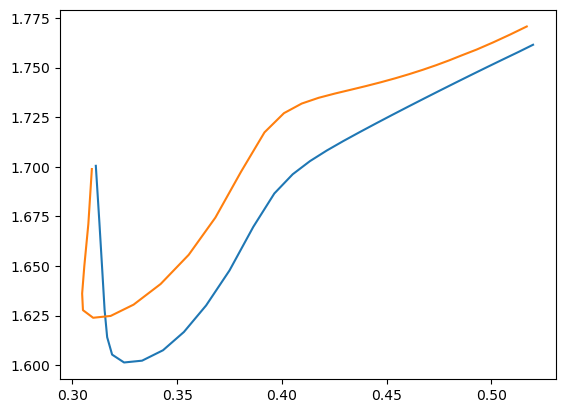

action1: actual angle = 53.93900173325987, pred_angle = 55.327409929561966


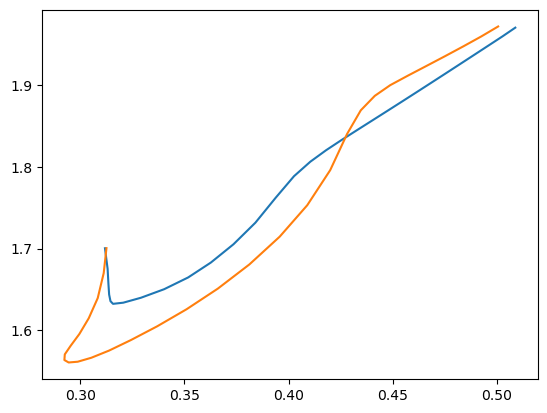

action2: actual angle = 72.55343461477538, pred_angle = 68.43281472808567


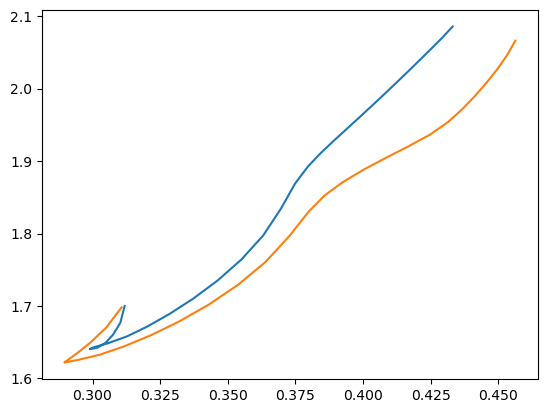

action3: actual angle = -89.36221808683219, pred_angle = -85.76122992519065


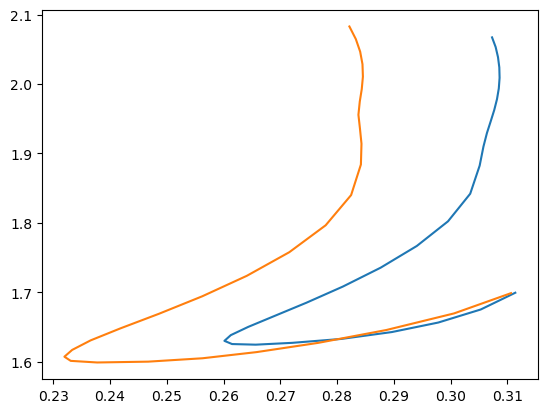

action4: actual angle = -56.08207290025826, pred_angle = -55.525878380785


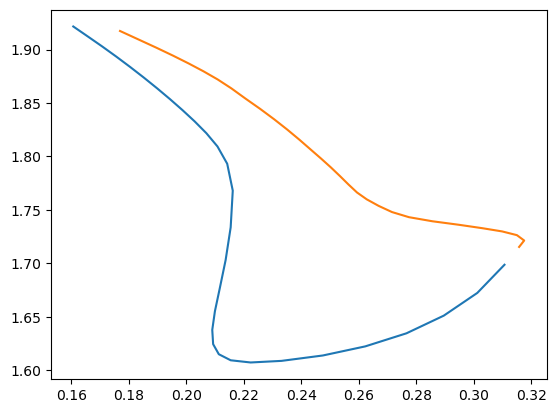

action5: actual angle = -3.352824362493359, pred_angle = -9.969592405969347


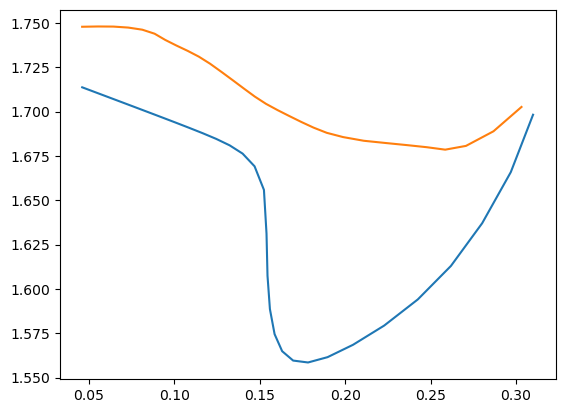

action6: actual angle = 31.036347807225397, pred_angle = 35.50291453291001


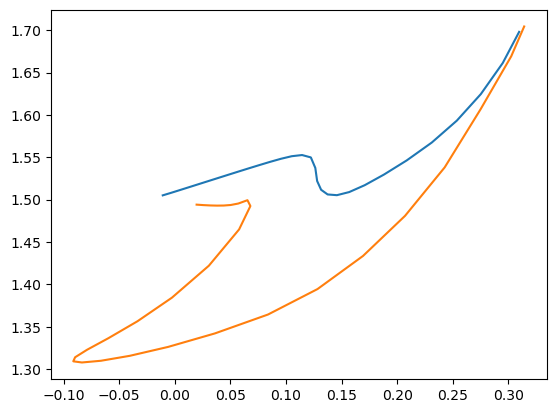

In [85]:
for act in range(valset.joint.shape[0]):
    obs_joints = valset.joint[act:act+1 , [29], :]  # only the first timestep is observed
    obs_landmarks = valset.landmark[act:act+1 , [29], :] 
    target_joints = valset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
    target_landmarks = valset.landmark[[act], :, :1]
    obs = (None, obs_landmarks)
    target = (target_joints, target_landmarks)
    with torch.no_grad():
        mean, std, land_1 , land_std = model_cp(obs, target,observation_mask=(None, None) )
    pred , pred_pos= get_angle(mean[0])
    org, org_pos = get_angle(valset.joint[act, :, 1:])
    print(f"action{act}: actual angle = {org}, pred_angle = {pred}")
    plt.plot(org_pos[:,1], org_pos[:,2], label = "robot")
    plt.plot(pred_pos[:,1], pred_pos[:,2], label = "pred")
    plt.show()

action0: actual angle = -18.175431326829987, pred_angle = -18.611162521549332


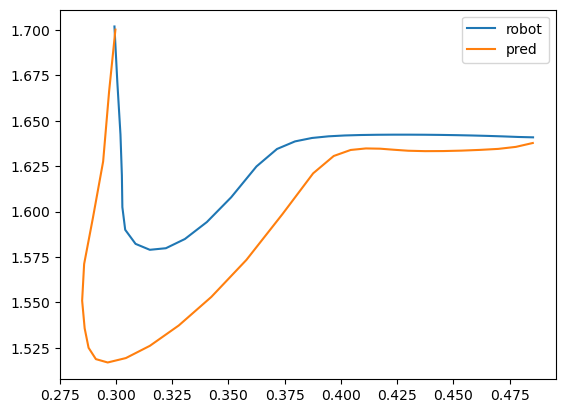

action1: actual angle = 39.080177558620925, pred_angle = 36.81884968177071


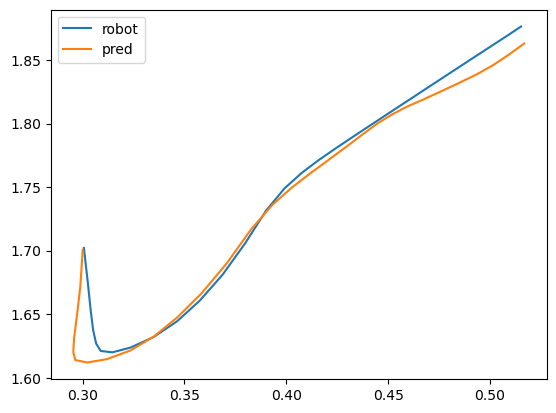

action2: actual angle = 64.23123934182776, pred_angle = 65.08095173588137


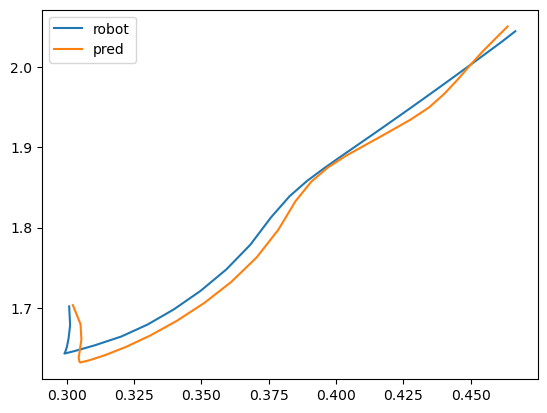

action3: actual angle = 81.23407763195586, pred_angle = 80.97318526315037


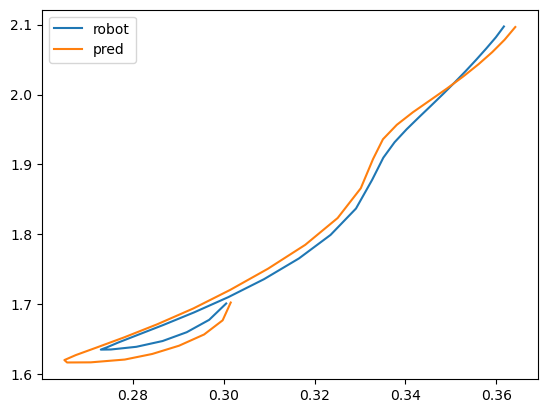

action4: actual angle = -74.7153143639671, pred_angle = -72.06212209420684


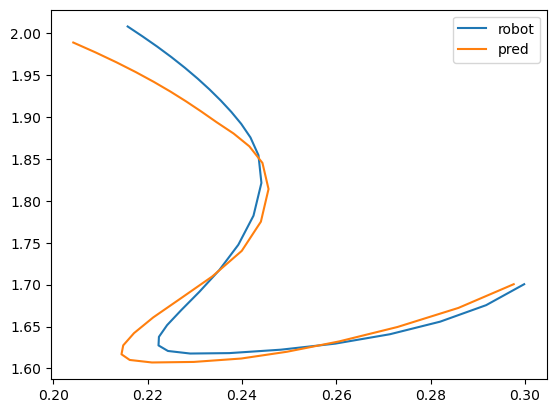

action5: actual angle = -29.38850967422988, pred_angle = -26.55161523385587


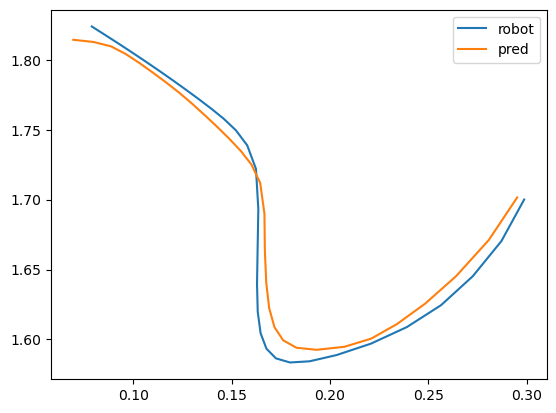

action6: actual angle = 16.777647848508618, pred_angle = 18.47312351979512


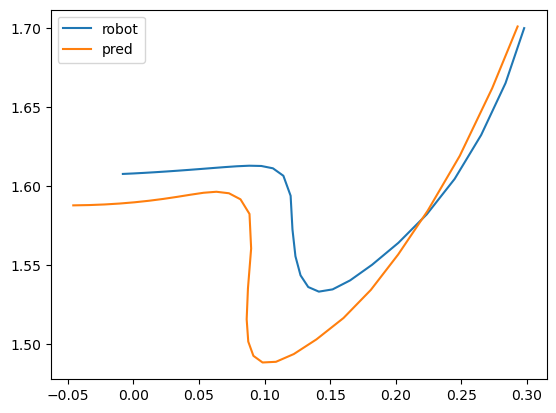

In [81]:
for act in range(trainset.joint.shape[0]):
    obs_joints = trainset.joint[act:act+1 , [5,10,15,20,25], :]  # only the first timestep is observed
    obs_landmarks = trainset.landmark[act:act+1 , [5,10,15,20,25], :] 
    target_joints = trainset.joint[[act], :, :1]  # doesn't matter which trajectory we use as target
    target_landmarks = trainset.landmark[[act], :, :1]
    obs = (None, obs_landmarks)
    target = (target_joints, target_landmarks)
    with torch.no_grad():
        mean, std, land_1 , land_std = model_cp(obs, target,observation_mask=(None, None) )
    pred , pred_pos= get_angle(mean[0])
    org, org_pos = get_angle(trainset.joint[act, :, 1:])
    print(f"action{act}: actual angle = {org}, pred_angle = {pred}")
    plt.plot(org_pos[:,1], org_pos[:,2], label = "robot")
    plt.plot(pred_pos[:,1], pred_pos[:,2], label = "pred")
    plt.legend()
    plt.show()